### Assignment 1

#### Done by German Devchich, 1-st year of Master degree ,Skoltech
#### 2024 Moscow

### Task 1: Configuration Space (40 points)

In [94]:
from utils import *
import numpy as np
from scipy.signal import convolve2d
from queue import PriorityQueue
from dataclasses import dataclass


##### **A (10 pts)** Visualize from the given data the workspace and the different rod configurations for each discretized orientation. Comment on the given discretized values for orientation

In [95]:
img = np.load('data_ps1.npz')
env = img['environment']
rod = img['rod']

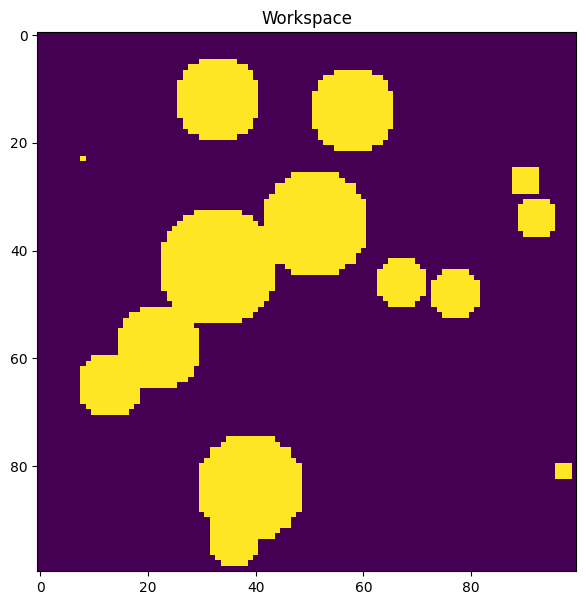

In [96]:
plt.figure(figsize=(14, 7))
plt.title("Workspace")
plt.imshow(env)
plt.show()

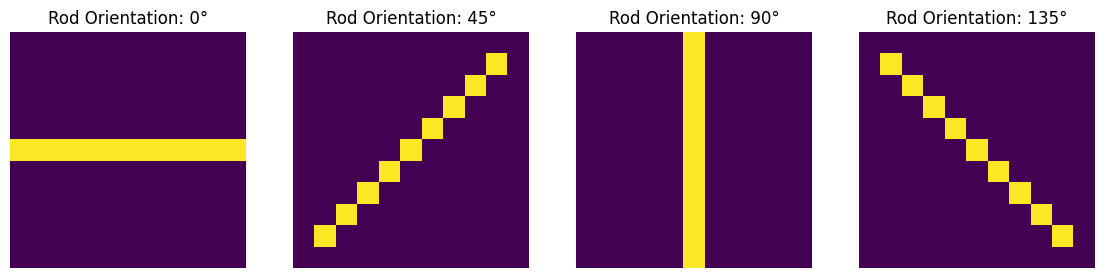

In [97]:
orientations = ["0°", "45°", "90°", "135°"]
fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for i in range(4):
    axs[i].imshow(rod[:, :, i])
    axs[i].set_title(f"Rod Orientation: {orientations[i]}")
    axs[i].axis('off')
plt.show()

The orientation of the robot is discretized with four angles: 0°, 45°, 90°, and 135°. This approach limits the possible angles the robot can take, but makes the calculations more efficient. For example, if the robot could rotate every degree, the size and complexity of the C-space would increase dramatically, making the computation less convenient.

##### **B (10 pts)** Visualize the environment together with the object. For this, you may want to use the function **plot_joint_environment** from **utils.py** and select any valid configuration value for the rod.

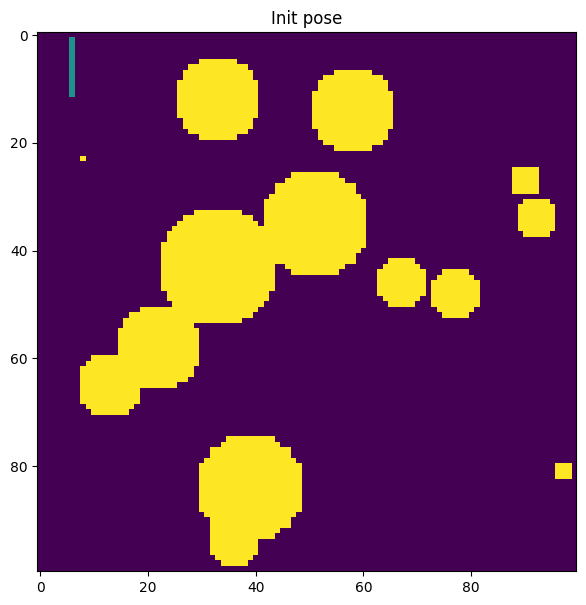

In [98]:
plt.figure(figsize=(14, 7))
plt.title("Init pose")
plt.imshow(plot_enviroment(img=env,obj=rod,state=(6,6,2)))
plt.show()

##### **C (10 pts)** Create the C-space for the 2D environment map. For this, plot all the images corresponding to each of the orientations by using collision checking.

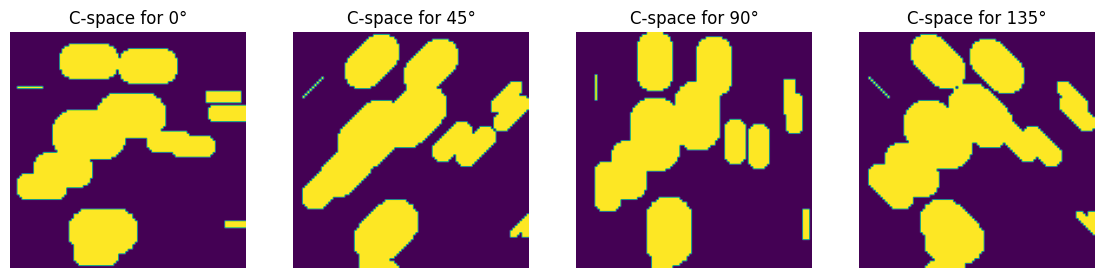

In [99]:
c_space = np.array([normalize_image(convolve2d(in1=env,in2=rod[:, :, i],boundary='symm', mode='same')) for i in range(4)])
orientations = ["0°", "45°", "90°", "135°"]
fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for i in range(c_space.shape[0]):
    axs[i].imshow(c_space[i])
    axs[i].set_title(f"C-space for {orientations[i]}")
    axs[i].axis('off')
plt.show()

##### **D (10 pts)** Comment on the obtained C-space with the previous method. What is the size of the C-space?

The created C-space for each robot orientation (four layers for 0°, 45°, 90° and 135°) has a dimension of 4, 100,100. It displays where the robot can be located while avoiding collisions. 

To build this space, a convolution with a kernel in the form of the position of our robot is used to determine the presence of obstacles for each robot orientation at each point on the map.

This space is subsequently used in the pathfinding algorithm.

### Task 2: A star Algorithm (60 points)
**A (40 pts)** You need to implement the A star algorithm and plan in the generated discrete C-space from the previous task. The starting configuration of the agent is $(6,6,2)$ and the goal configuration is $(72,64,0)$. On this first iteration, use an heuristic function $h(q,q_G) = 0$, which is equivalent to the Dijkstra algorithm.

Save the result of calculated plan in **rod_solve.mp4** using **plotting_result(environment,rod,plan)** from **utils.py**, where plan is list of rod states from start to goal.

**hint**: Track the number of visited states to avoid/debug potential issues with internal loops

In [102]:
def a_star(init_pose: np.ndarray, final_pose: np.ndarray, env_map: np.ndarray, useHeuristic=True):

    num_layers = env_map.shape[0]
    
    def heuristic(x1, x2):
        if useHeuristic:
            return abs(x1[0]-x2[0])+abs(x1[1]-x2[1])
        else:
            return 0
    
    def state_evolution(x_current, cost_current):
        xy_cost = 1
        rot_cost = 1
        transitions = np.array([
            [1, 0, 0, xy_cost],
            [-1, 0, 0, xy_cost],
            [0, 1, 0, xy_cost],
            [0, -1, 0, xy_cost],
            [0, 0, 1, rot_cost],
            [0, 0, -1, rot_cost]
        ])
        
        future_states = []
        for transition in transitions:
            prob_x = x_current + transition[:3]
            cost_future = cost_current + transition[3]
            prob_x[2] %= num_layers  # normalizing angle
            
            x = prob_x[0]
            y = prob_x[1]
            theta = int(prob_x[2])
            
            # Calculating boundings of map 
            dim_y = int((rod.shape[0] - 1) / 2)
            dim_x = int((rod.shape[1] - 1) / 2)
            
            y_min = y - dim_y
            y_max = y + dim_y + 1
            x_min = x - dim_x
            x_max = x + dim_x + 1
            
            # make sure that the current pose are in the bounding of map
            if y_min < 0 or x_min < 0 or y_max > env_map.shape[1] or x_max > env_map.shape[2]:
                continue 
            
            # Check collision in the c_space
            if env_map[int(theta), int(x), int(y)] == 0:
                future_states.append((prob_x, cost_future))
        return future_states

    q = PriorityQueue()
    q.put((0, tuple(init_pose))) 
    
    came_from = {}
    c_cost = {tuple(init_pose): 0}
    f_score = {tuple(init_pose): heuristic(init_pose, final_pose)}
    
    already_visited = set()
    already_visited.add(tuple(init_pose))

    while not q.empty():
        _, x_current = q.get()
        
        if np.array_equal(x_current, final_pose):
            plan = []
            while tuple(x_current) in came_from:
                plan.append(x_current)
                x_current = came_from[tuple(x_current)]
            plan.append(init_pose)
            print("Find path")
            final_cost = c_cost.get(tuple(x_current), -1)
            print(f"Final cost: {final_cost}")
            standardized_plan = [tuple(map(int, state)) for state in plan[::-1]]
            return standardized_plan 

        for prob_x, cost_future in state_evolution(np.array(x_current), c_cost[x_current]):
            prob_x_tuple = tuple(prob_x)
            
            if prob_x_tuple in already_visited:
                continue
            
            tentative_c_cost = c_cost[x_current] + cost_future
            
            if prob_x_tuple not in c_cost or (tentative_c_cost < c_cost[prob_x_tuple]):
                came_from[prob_x_tuple] = x_current
                c_cost[prob_x_tuple] = tentative_c_cost
                f_score[prob_x_tuple] = tentative_c_cost + heuristic(prob_x, final_pose)
                
                already_visited.add(prob_x_tuple)
                q.put((f_score[prob_x_tuple], prob_x_tuple))

    print("Путь не найден")
    return None 

/var/folders/m3/s66gcfbn4lj4tb84p633t5qc0000gn/T/ipykernel_43640/16174487.py:87: RuntimeWarning: overflow encountered in scalar add
  f_score[prob_x_tuple] = tentative_c_cost + heuristic(prob_x, final_pose)
/var/folders/m3/s66gcfbn4lj4tb84p633t5qc0000gn/T/ipykernel_43640/16174487.py:26: RuntimeWarning: overflow encountered in scalar add
  cost_future = cost_current + transition[3]


Find path
Final cost: 0
Length of the path: 127


MovieWriter ffmpeg unavailable; using Pillow instead.


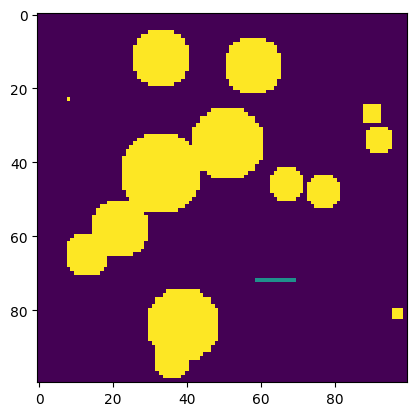

In [103]:
init_pose = np.array([6, 6, 2])  
final_pose = np.array([72, 64, 0])   
path = a_star(init_pose, final_pose, c_space,useHeuristic=True)
print(f"Length of the path: {len(path)}")
plotting_results(environment=env, rod=rod, plan=path, save_path='rod_solve.gif')